# 3. Model tests
## 3.02 Example: Linear Regression Model

In [1]:
import sys
sys.path.append("../../")
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dask
dask.config.set(scheduler='threads')
import xarray as xr
sys.path.append("../../")
from python.aux.utils_floodmodel import reshape_multiday_predictand
from python.aux.utils_floodmodel import add_future_vars
from python.aux.verification import verify, ME, RMSE, RMSE_persistence, NSE, NSE_diff

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data.

The features are already prepared and ready to use, hence why they can be loaded directly from the `features_xy.nc` file.

Let's open the files and see what's in there:

In [3]:
# load data
version = 'v1'

if version == 'v1':
    features = xr.open_dataset('../../data/features_xy.nc')
    y = features['dis']
    X = features.drop(['dis'])
elif version == 'v2':
    features = xr.open_dataset('../../data/features_xy_v2.nc')
    y = features['dis']
    X = features.drop(['dis', 'dis_diff'])

In [4]:
features

<xarray.Dataset>
Dimensions:     (time: 5478)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude    float64 ...
    longitude   float64 ...
Data variables:
    cp          (time) float64 ...
    lsp         (time) float64 ...
    swvl1       (time) float64 ...
    ro          (time) float64 ...
    sd          (time) float64 ...
    lsp-1       (time) float64 ...
    lsp-2       (time) float64 ...
    lsp-3       (time) float64 ...
    lsp-4-10    (time) float64 ...
    lsp-11-24   (time) float64 ...
    lsp-25-54   (time) float64 ...
    lsp-55-180  (time) float64 ...
    cp-1        (time) float64 ...
    cp-2        (time) float64 ...
    cp-3        (time) float64 ...
    sd_diff     (time) float64 ...
    dis         (time) float64 ...

Some control parameters for the procedure:

 * `add_shift_switch`: Shift and add shifted values as new features for multi-day forecasts. (only needed if forecasting multiple days at once => currently only implemented with nns!)
 * `dis_shift_1`: Add the discharge from the last day as additional feature for testing purposes.
 * `abs_vals_switch`: Model is trained on absolute discharge values if True and on differences/change in discharge else.

In [5]:
dis_shift_switch = False

In [6]:
abs_vals_switch = False

Begin with some short preprocessing..

In [7]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [8]:
X_base = X.to_array(dim='features').T
y_base = y

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [9]:
period_train = dict(time=slice(None, '1990'))
period_valid = dict(time=slice('1991', '1993'))
period_test = dict(time=slice('1994', '1995'))

In [10]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [11]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series."""
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

In [12]:
X_train.shape, y_train.shape

((3652, 16), (3652,))

In [13]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

In [14]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.linear_model import LinearRegression

# Define LinearRegressionModel

In [15]:
Xda.values.shape, yda.values.shape

((3373, 16), (3373,))

In [16]:
model = LinearRegression(n_jobs=-1,
                         random_state=0,
                         verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

pipe.fit(Xda.values, yda.values)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LinearRegression(C=1.0, class_weight=None, dual=False,
                                  fit_intercept=True, intercept_scaling=1.0,
                                  max_iter=100, multi_class='ovr', n_jobs=-1,
                                  penalty='l2', random_state=0, solver='admm',
                                  solver_kwargs=None, tol=0.0001, verbose=True,
                                  warm_start=False))],
         verbose=True)

### in sample test for the predicted change, to verify functionality

In [17]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

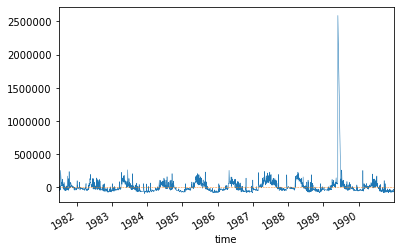

In [18]:
insample_check = pipe.predict(Xda.values)
insample_check = add_time(insample_check, Xda.index, name='forecast')
insample_check.to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

Set the frequency at which forecast are started.

In [19]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n]
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)
# clean vars
del pipe
del model

<xarray.DataArray 'forecast' (time: 1096)>
array([ 14.965273,  23.423568,  36.414403, ..., -30.998429, -29.888202,
       -13.315229])
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1993-12-31


In [20]:
def plot_pred_series(x, y, y_truth, forecast_range=14):
    """Convenience function for converting the prediction output in xr.DataArray with the sa"""
    # assuming x has a resolution of 1 day, else a key error will result.
    dt = x.time[1]-x.time[0]
    # create prediction series containing nans
    pred = x.copy().isel(features=0)*np.nan
    # rename and drop unnecessary stuff
    pred.name = 'prediction'
    pred = pred.drop('features')
    # add truth at time t=t0 for each forecast
    y_steps = y[1::forecast_range].copy()
#    print(pred)
    pred.loc[y_steps.time-dt] = y_truth.loc[y_steps.time-dt]
    pred.loc[y_steps.time] = y_steps + pred.loc[y_steps.time-dt].values
    
    # add multiple forecast days onto prediction
    yinit = x.time.dt.year[0].values
    tinit = f"{yinit}-01-01"
    yend = x.time.dt.year[-1].values
    tend = f"{yend}-12-31"
    time_vec = y_steps.time.copy()
    for i in range(1, forecast_range-2):
        tind = (y_steps.time+dt*i).sel(time=slice(tinit, tend))
        try: # easy way to ignore indexing out of the date range, happens only at the jump upwards of the boundary
            pred.loc[tind] = y.loc[tind] + pred.loc[tind-dt].values
        except:
            pred.loc[tind[:-1]] = y.loc[tind[:-1]] + pred.loc[tind[:-1]-dt].values
    
    fig, ax = plt.subplots(figsize=(15,5))
    y_truth.sel({'time': x.time}).to_pandas().plot(ax=ax, label='truth')
    pred.to_pandas().plot(ax=ax, label='forecast')
    plt.legend()
    ax.set_ylabel('river discharge [m$^3$/s]')
    return pred

In [21]:
print(y_valid)

<xarray.DataArray 'dis' (time: 1096)>
array([ 602.04248 ,  609.904907,  632.579773, ..., 1132.167725, 1123.2948  ,
       1120.796753])
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1993-12-31
    latitude   float64 ...
    longitude  float64 ...
Attributes:
    long_name:  discharge
    units:      m3/s


Text(0.5, 1.0, 'LinearRegressionModel |\xa0RMSE=203.08; NSE=0.86')

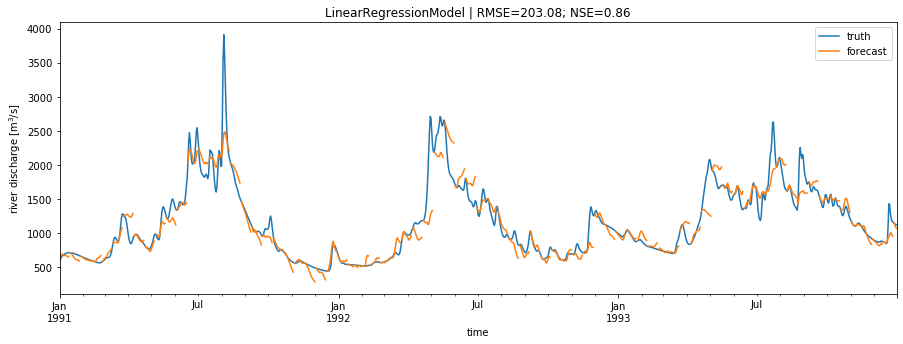

In [22]:
pred = plot_pred_series(X_pred, y_pred, y, forecast_range=14)

# calculate RMSE and NSE and put it in the plot title
# differences
#y_o = y_valid.diff(dim='time')
#y_m = y_pred.where(y_o, drop=True)
# absolute values
y_o = y_valid
y_m = pred

rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

plt.title(f"LinearRegressionModel | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)}")

#### Check the skill of a 14-day persistence forecast:

In [23]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=251.09; NSE=0.77


|   varying param     |   RMSE   |   NSE   | 
| :--------: | :-----: | :-----: | 
| LinearRegressionModel | 203.08 | 0.86 |
| --------------- | --------------- | --------------- |
| persistence 14-day forecast  | 251.09 | 0.77 |


Concluding, even though the Linear Regression Model is very simple, it captures a lot of the development parts correctly and is better than the 14-day persistence forecast (which is the absolute minimum threshold a model has to reach, else it would have no skill and be worthless).